# #1 K_Medoids (cdist DTW) with Tslearn

Para interpretar y validar los resultados del modelo de clustering aplicado a series temporales de consumo eléctrico, se han generado varias visualizaciones complementarias:

In [ ]:
import pandas as pd
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMinMax
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
modelo_kmeans = load('kmeans_dtw_minmax_normalized.joblib')
df = pd.read_csv("../../../data/vertical_preprocessed_data.csv", sep=";")

class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.scaler = TimeSeriesScalerMinMax() if normalize else None
        
    def transform(self, X):
        X_sorted = X.sort_values(by=['cups', 'fecha', 'hora'])
        series_list = []
        
        for _, group in X_sorted.groupby('cups'):
            series_list.append(group['consumo_kWh'].values)
            
        if self.normalize:
            series_array = np.array([np.reshape(s, (-1, 1)) for s in series_list])
            return [self.scaler.fit_transform(series_array)[i].flatten() 
                   for i in range(len(series_array))]
        return series_list


preprocessor = TimeSeriesPreprocessor(normalize=True)
series_normalizadas = preprocessor.transform(df)

plt.figure(figsize=(14, 7))
for cluster_id in range(modelo_kmeans.n_clusters):
    plt.plot(modelo_kmeans.cluster_centers_[cluster_id].ravel(),  
             linewidth=2.5,
             label=f'Cluster {cluster_id} (n={(modelo_kmeans.labels_ == cluster_id).sum()})')

plt.title("Centroides de Clusters - K-Means con DTW", pad=15)
plt.xlabel("Índice Temporal", fontsize=12)
plt.ylabel("Consumo Normalizado [0-1]", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

C:\Users\tipir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Distribución de viviendas por clúster

Esta gráfica muestra cuántas viviendas han sido asignadas a cada clúster. Es útil para identificar si el modelo ha generado clústeres equilibrados o si existe alguno con una concentración excesiva o demasiado escasa de viviendas, lo cual puede indicar un agrupamiento poco representativo o la presencia de valores atípicos.

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=modelo_kmeans.labels_, palette='Set2')
plt.title("Distribución de viviendas por clúster (K-Means + DTW)")
plt.xlabel("Clúster")
plt.ylabel("Número de viviendas")
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'plt' is not defined

## Series representativas (centroides) por clúster

Los centroides son las series reales dentro del conjunto de datos que mejor representan a cada clúster, al minimizar la distancia total a las demás series del mismo grupo. Visualizar estos centroides permite tener una idea clara del patrón de consumo "promedio" o más característico dentro de cada clúster, facilitando su interpretación.

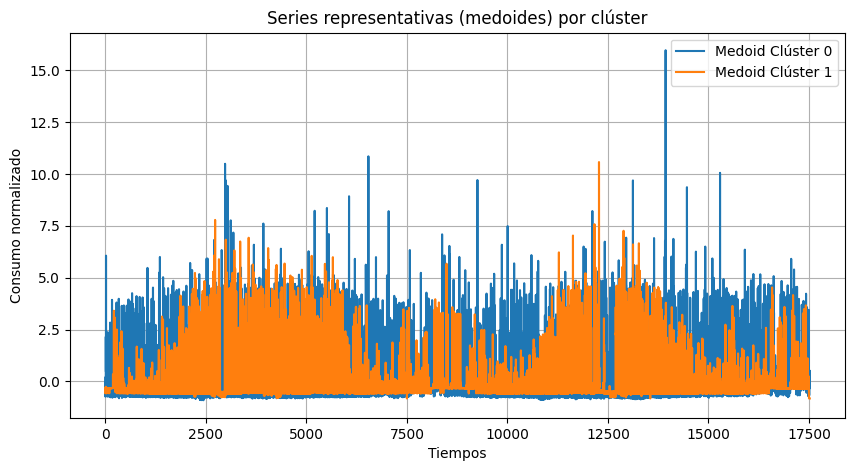

In [ ]:
plt.figure(figsize=(14, 7))
for cluster_id in range(modelo_kmeans.n_clusters):
    plt.plot(modelo_kmeans.cluster_centers_[cluster_id].ravel(),
             linewidth=2.5,
             label=f'Cluster {cluster_id} (n={(modelo_kmeans.labels_ == cluster_id).sum()})')

plt.title("Centroides de Clusters - K-Means con DTW", pad=15)
plt.xlabel("Índice Temporal", fontsize=12)
plt.ylabel("Consumo Normalizado [0-1]", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## Series de tiempo por clúster con su centroide

En esta figura se representan todas las series asignadas a cada clúster, superpuestas, junto al centroide correspondiente. Esta visualización permite evaluar la homogeneidad interna de cada grupo y observar si las series siguen patrones similares o si hay mucha variabilidad. También permite contrastar visualmente la centralidad del medoide.

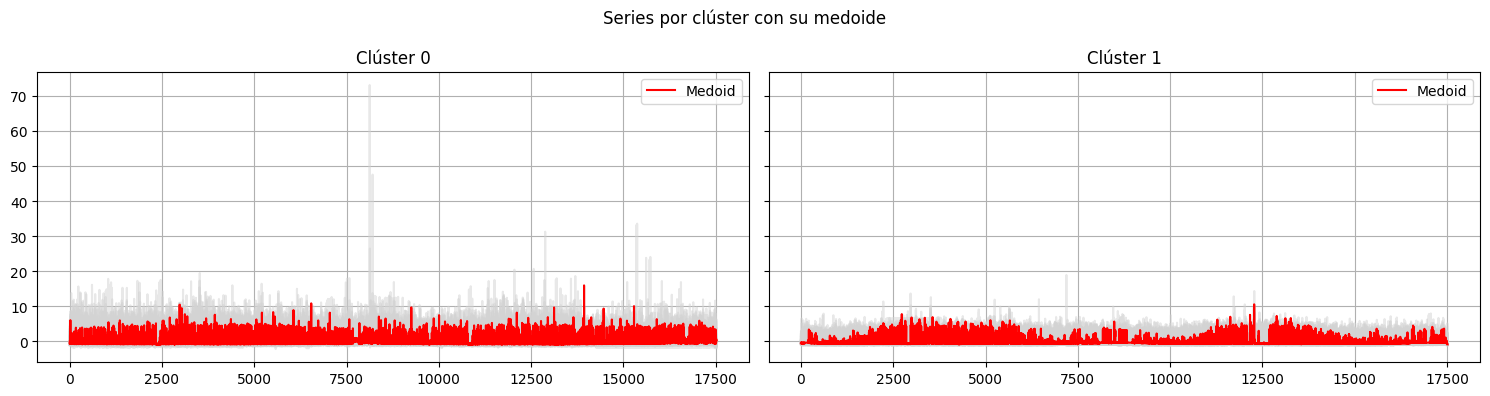

In [ ]:
fig, axes = plt.subplots(1, modelo_kmeans.n_clusters, figsize=(15, 4), sharey=True)

for cluster_id in range(modelo_kmeans.n_clusters):
    ax = axes[cluster_id]
    cluster_mask = (modelo_kmeans.labels_ == cluster_id)
    
    # Graficar todas las series del cluster
    for idx in np.where(cluster_mask)[0]:
        ax.plot(series_normalizadas[idx], color='lightgray', alpha=0.3)
    
    # Graficar el centroide
    ax.plot(modelo_kmeans.cluster_centers_[cluster_id].ravel(), 
            color='red', linewidth=2, label='Centroide')
    
    ax.set_title(f'Cluster {cluster_id} (n={cluster_mask.sum()})')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle("Series por clúster con su centroide (K-Means)")
plt.tight_layout()
plt.show()

## Proyección PCA en 2D de las series

Se utiliza Análisis de Componentes Principales (PCA) para reducir la dimensión de las series temporales y representar cada vivienda como un punto en un espacio bidimensional. Esta proyección permite observar visualmente la separabilidad entre clústeres, verificando si están claramente diferenciados o si existe solapamiento entre ellos. Es una herramienta exploratoria clave para validar la calidad del clustering desde una perspectiva geométrica.

In [ ]:
X_array = np.array(series_normalizadas)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_array)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
                hue=modelo_kmeans.labels_, palette='Set2', 
                alpha=0.7, edgecolor='w')

centers_pca = pca.transform(
    np.array([c.ravel() for c in modelo_kmeans.cluster_centers_])
for cluster_id in range(modelo_kmeans.n_clusters):
    plt.scatter(centers_pca[cluster_id, 0], centers_pca[cluster_id, 1],
               s=200, marker='*', c=[plt.cm.Set2(cluster_id)],
               edgecolor='k', linewidth=1, label=f'Centroide {cluster_id}')
)
plt.title("Visualización 2D (PCA) - K-Means\nVarianza explicada: {:.2f}%".format(
    sum(pca.explained_variance_ratio_)*100))
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


SyntaxError: '(' was never closed (1223891960.py, line 11)